In [1]:
!pip install seaborn
!pip install nltk
!pip install datasets

import nltk
import seaborn as sns
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
import heapq
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from keras.optimizers import RMSprop
import datasets

nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 524.4 kB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 437.2 kB/s eta 0:00:001m495.9 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 247.6 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 284.7 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 552.3 kB/s eta 0:00:001m682.1 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 375.2 kB/s eta 0:00:00m eta 0:00:010:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 832.7 kB/s eta 0:00:00m eta 0:00:01
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)


2023-05-22 20:49:11.030626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/belinda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel('./writing_aid_dataset.xlsx')

# Print the head of the DataFrame
print(df.head())

                                            English
0         december is the twelfth month of the year
1             mr. ddumba is our teacher for English
2                               where are you going
3  when i was going to kampala i saw kalerwe market
4                          kasanje is my sub-county


In [3]:
# Tokenize English sentences
regexp = RegexpTokenizer('\w+')

df['eng_token']=df['English'].apply(regexp.tokenize)
print(df.head())

                                            English   
0         december is the twelfth month of the year  \
1             mr. ddumba is our teacher for English   
2                               where are you going   
3  when i was going to kampala i saw kalerwe market   
4                          kasanje is my sub-county   

                                           eng_token  
0  [december, is, the, twelfth, month, of, the, y...  
1       [mr, ddumba, is, our, teacher, for, English]  
2                           [where, are, you, going]  
3  [when, i, was, going, to, kampala, i, saw, kal...  
4                     [kasanje, is, my, sub, county]  


In [4]:
# remove stop words
stopwords = nltk.corpus.stopwords.words("english")

df['eng_token'] = df['eng_token'].apply(lambda x: [item.lower() for item in x if item not in stopwords])
df['eng_string'] = df['eng_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
print(df.head(3))

                                     English   
0  december is the twelfth month of the year  \
1      mr. ddumba is our teacher for English   
2                        where are you going   

                          eng_token                   eng_string  
0  [december, twelfth, month, year]  december twelfth month year  
1    [mr, ddumba, teacher, english]       ddumba teacher english  
2                           [going]                        going  


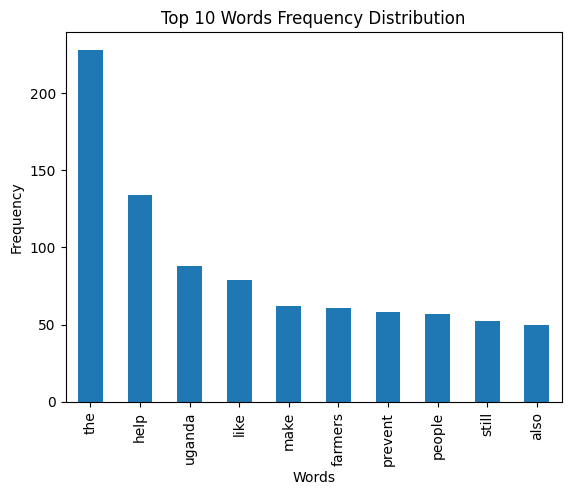

In [5]:
# Access the tokenized words column and parse tokens into a list
eng_words_list = [word for sentence in df['eng_string'] for word in sentence.split()]

# Create frequency distribution of the tokens
freq_dist = pd.Series(eng_words_list).value_counts()

# Plot the top 10 words
top_10_words = freq_dist.head(10)
top_10_words.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency Distribution')

# Display the plot
plt.show()

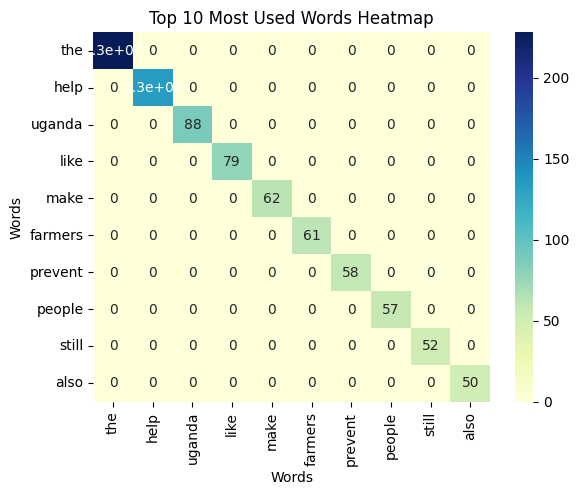

In [6]:
# Calculate word frequencies
word_counts = pd.Series(eng_words_list).value_counts()

# Select the top 10 most used words
top_10_words = word_counts.head(10)

# Create a matrix-like representation with the top 10 words
word_matrix = pd.DataFrame(index=top_10_words.index, columns=top_10_words.index)

# Fill the matrix with word frequencies
for word1 in word_matrix.index:
    for word2 in word_matrix.columns:
        if word1 == word2:
            word_matrix.loc[word1, word2] = top_10_words[word1]
        else:
            word_matrix.loc[word1, word2] = 0

# Convert the matrix values to numeric
word_matrix = word_matrix.astype(int)

# Create the heatmap using seaborn
sns.heatmap(word_matrix, annot=True, cmap='YlGnBu')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Words')
plt.title('Top 10 Most Used Words Heatmap')

# Display the plot
plt.show()

In [40]:
import pandas as pd
from datasets import load_dataset

# Load the Tatoeba dataset for English and Luganda using load_dataset()
new_dataset = load_dataset('sbmaruf/forai_ml_masakhane_mafand', 'en-lug')

# Access the train split of the dataset
train_dataset = new_dataset['train']

# Convert the train split to a Pandas DataFrame
df = pd.DataFrame(train_dataset)

# Select only the 'source' and 'target' columns
df = df[['source', 'target']]

# Print the head of the DataFrame
print(df.tail())

Found cached dataset forai_ml_masakhane_mafand (/home/belinda/.cache/huggingface/datasets/sbmaruf___forai_ml_masakhane_mafand/en-lug/1.0.0/5983862e8f5e8cbca281d4e2ad5a14eb519b574d59f49faad0d7f107d12a3912)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                 source   
4070  He writes that the report accuses the UPDF of ...  \
4071  Although UPDF crimes are far more pronounced i...   
4072  Yet if individuals such as Minister Kutesa, ou...   
4073  Thousands of Hema children allegedly recruited...   
4074  They probably did not have to meet UJA, after ...   

                                                 target  
4070  Yawandiika nti alipoota erumika UPDF okuzza em...  
4071  Wadde ng'emisango gya UPDF gino girabika nga g...  
4072  Kati bwe kiba nti abantu nga minisita Kuteesa ...  
4073  Enkumi n'enkumi z'abaana abagambibwa nti baawa...  
4074  Oboolyawo kyali tekibeetaagisa kusisinkana UJA...  


In [41]:
df.shape

(4075, 2)

In [42]:
regexp = RegexpTokenizer('\w+')

df['source_tokens']=df['source'].apply(regexp.tokenize)
df['target_tokens']=df['target'].apply(regexp.tokenize)
print(df.head())

                                              source   
0  Why don't they want to accept the people of Ug...  \
1  Only three National Resistance Movement offici...   
2  Basajja could represent Uganda in boxing contest.   
3  The hides and skins businessman showed fellow ...   
4  He descended on a New Vision photo journalist,...   

                                              target   
0  Lwaki tebaagala kukkiriza nti bannayuganda teb...  \
1  Abakulu mu National Resistance Movement basatu...   
2  Basajja yandikiikiridde Uganda mu mpaka z'ebik...   
3  Omusuubuzi w'amaliba n'ebirenge yalagako banne...   
4  Yayogedde ku kifaananyi kya munnamawulire mu N...   

                                       source_tokens   
0  [Why, don, t, they, want, to, accept, the, peo...  \
1  [Only, three, National, Resistance, Movement, ...   
2  [Basajja, could, represent, Uganda, in, boxing...   
3  [The, hides, and, skins, businessman, showed, ...   
4  [He, descended, on, a, New, Vision, photo, 

In [44]:
!pip install spacy
import spacy
from spacy.lang.lg import Luganda

eng_stopwords = nltk.corpus.stopwords.words("english")
lug_stopwords = Luganda.Defaults.stop_words

df['target_tokens'] = df['target_tokens'].apply(lambda x: [item.lower() for item in x if item.lower() not in lug_stopwords])
df['source_tokens'] = df['source_tokens'].apply(lambda x: [item.lower() for item in x if item not in eng_stopwords])

print(df.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 795.4 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 738.5 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 474.4 kB/s eta 0:00:00 kB/s eta 0:00:01
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 632.9 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 496.2 kB/s eta 0:00:0031m2.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 887.5 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 332.4 kB/s eta 0:00:00m eta 0:00:010:00:01
                                              source   
0  Why don't they want to

In [45]:
df['src_string'] = df['source_tokens'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df['tgt_string'] = df['target_tokens'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

df.head()

,source,target,source_tokens,target_tokens,src_string,tgt_string
0,Why don't they want to accept the people of Ug...,Lwaki tebaagala kukkiriza nti bannayuganda teb...,"[why, want, accept, people, uganda, trust, job]","[tebaagala, kukkiriza, bannayuganda, tebabeesi...",why want accept people uganda trust job,tebaagala kukkiriza bannayuganda tebabeesiga k...
1,Only three National Resistance Movement offici...,Abakulu mu National Resistance Movement basatu...,"[only, three, national, resistance, movement, ...","[abakulu, national, resistance, movement, basa...",only three national resistance movement offici...,abakulu national resistance movement basatu re...
2,Basajja could represent Uganda in boxing contest.,Basajja yandikiikiridde Uganda mu mpaka z'ebik...,"[basajja, could, represent, uganda, boxing, co...","[basajja, yandikiikiridde, uganda, mpaka, z, e...",basajja could represent uganda boxing contest,basajja yandikiikiridde uganda mpaka ebikonde
3,The hides and skins businessman showed fellow ...,Omusuubuzi w'amaliba n'ebirenge yalagako banne...,"[the, hides, skins, businessman, showed, fello...","[omusuubuzi, w, amaliba, n, ebirenge, yalagako...",the hides skins businessman showed fellow dele...,omusuubuzi amaliba ebirenge yalagako banne nki...
4,"He descended on a New Vision photo journalist,...",Yayogedde ku kifaananyi kya munnamawulire mu N...,"[he, descended, new, vision, photo, journalist...","[yayogedde, kifaananyi, kya, munnamawulire, ne...",descended new vision photo journalist arthur k...,yayogedde kifaananyi kya munnamawulire new vis...


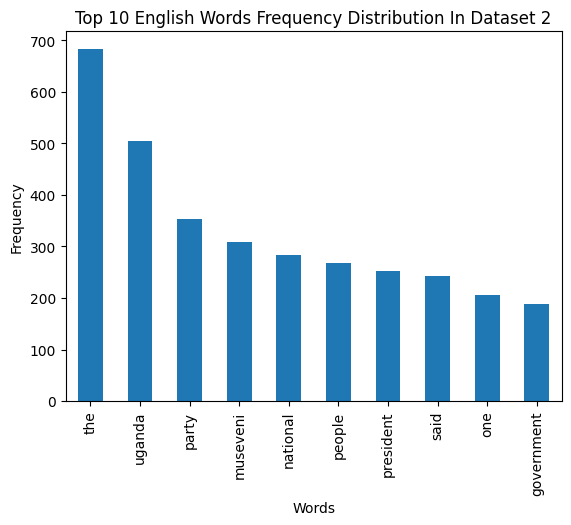

In [47]:
# Access the tokenized words column and parse tokens into a list
src_words_list = [word for sentence in df['src_string'] for word in sentence.split()]

# Create frequency distribution of the tokens
freq_dist = pd.Series(src_words_list).value_counts()

# Plot the top 10 words
top_10_words = freq_dist.head(10)
top_10_words.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 English Words Frequency Distribution In Dataset 2')

# Display the plot
plt.show()

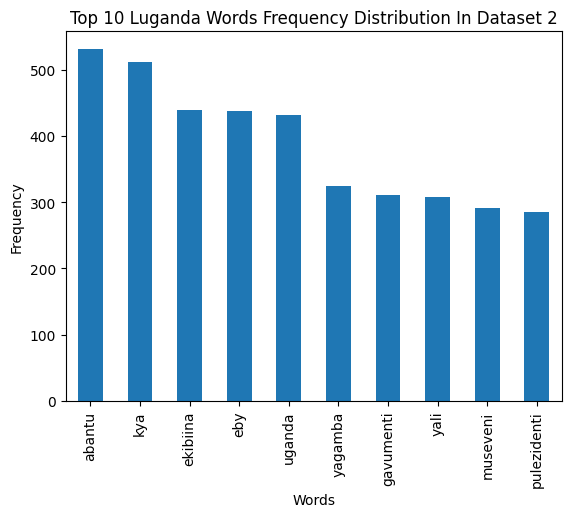

In [48]:
# Access the tokenized words column and parse tokens into a list
tgt_words_list = [word for sentence in df['tgt_string'] for word in sentence.split()]

# Create frequency distribution of the tokens
freq_dist = pd.Series(tgt_words_list).value_counts()

# Plot the top 10 words
top_10_words = freq_dist.head(10)
top_10_words.plot(kind='bar')

# Set plot labels and title
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Luganda Words Frequency Distribution In Dataset 2')

# Display the plot
plt.show()

In [51]:
!pip install wordcloud

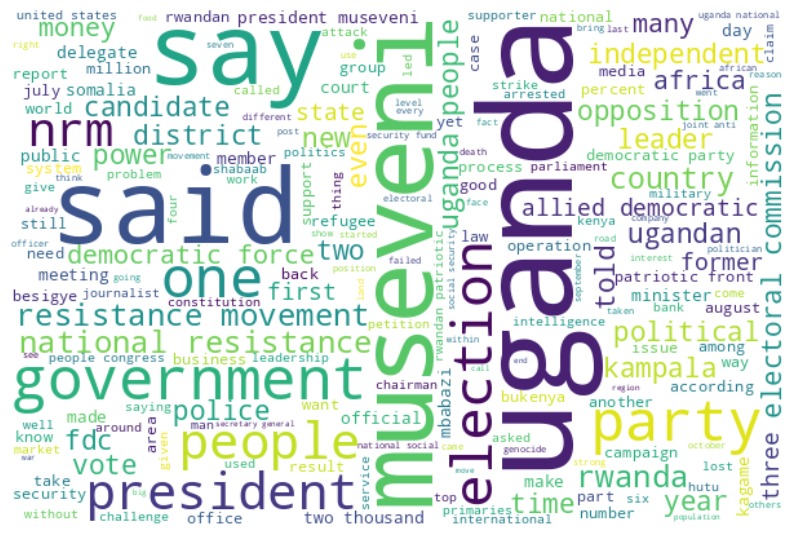

In [56]:
from wordcloud import WordCloud

eng_words = ' '.join([word for word in df['src_string']])
# all_words_lem

lug_words = ' '.join([word for word in df['tgt_string']])

# English Wordcloud
eng_wordcloud = WordCloud(background_color="white", width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(eng_words)

plt.figure(figsize=(10, 7))
plt.imshow(eng_wordcloud, interpolation='bilinear')
plt.axis('off');

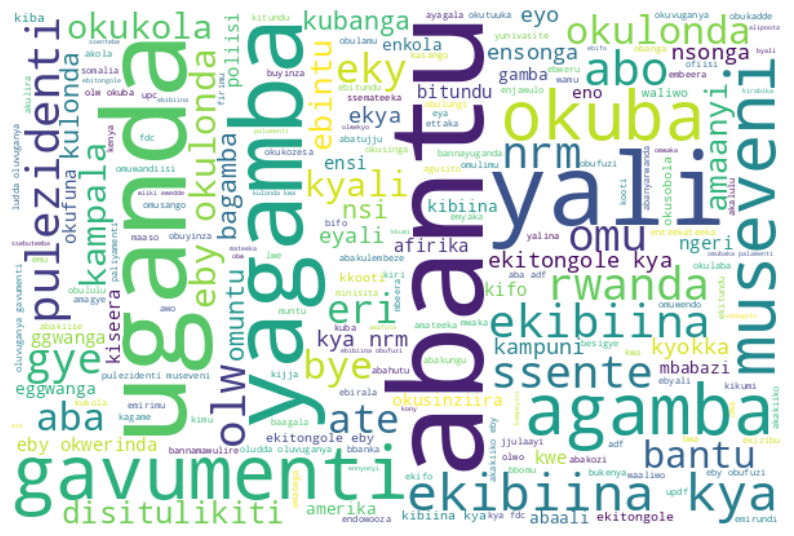

In [58]:
# Luganda Word Cloud
lug_wordcloud = WordCloud(background_color="white", width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(lug_words)

plt.figure(figsize=(10, 7))
plt.imshow(lug_wordcloud, interpolation='bilinear')
plt.axis('off');

In [67]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 19.6 kB/s eta 0:00:00m eta 0:00:010:00:02


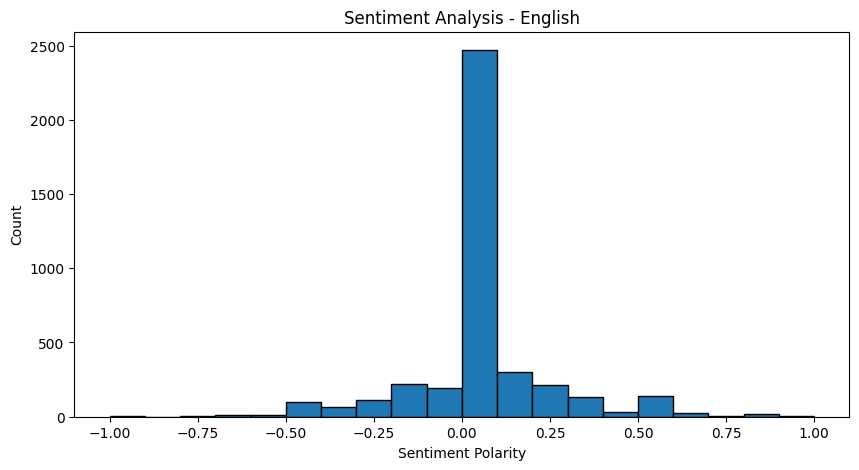

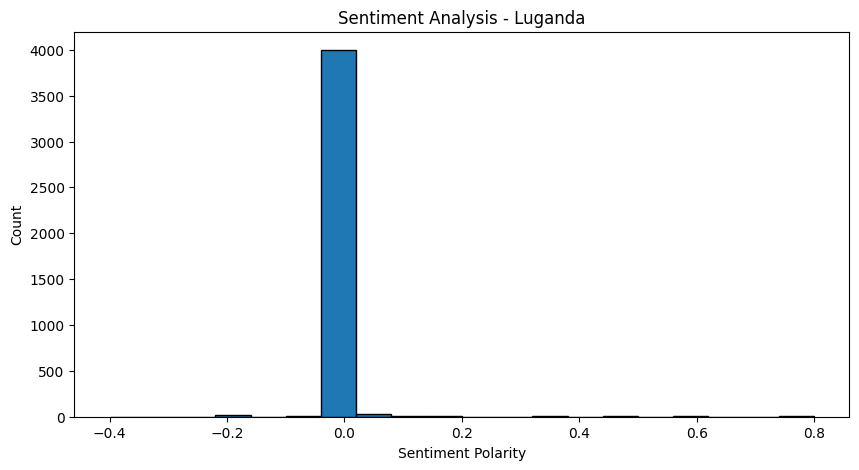

In [68]:
from textblob import TextBlob

# Calculate sentiment polarity for English strings
df['eng_sentiment'] = df['src_string'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate sentiment polarity for Luganda strings
df['lug_sentiment'] = df['tgt_string'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot the sentiment for English strings
plt.figure(figsize=(10, 5))
plt.hist(df['eng_sentiment'], bins=20, edgecolor='k')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.title('Sentiment Analysis - English')
plt.show()

# Plot the sentiment for Luganda strings
plt.figure(figsize=(10, 5))
plt.hist(df['lug_sentiment'], bins=20, edgecolor='k')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.title('Sentiment Analysis - Luganda')
plt.show()